In [1]:
import firedrake as fd
import matplotlib.pyplot as plt
import numpy as np
import ufl
import control

import hydrogym.firedrake as hgym
from lti_system import control_vec
from step_response import LinearBDFSolver

output_dir = "../eig_output"
# output_dir = "../re40_med_eig_output"
output_dir = "../re100_med_eig_output"
# output_dir = "../re40_fine_eig_output"

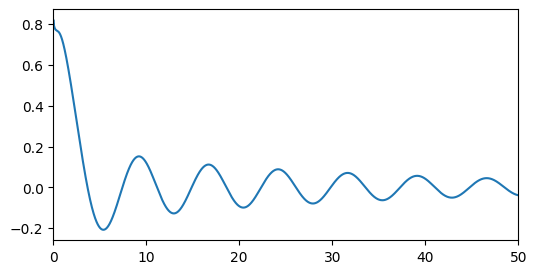

In [2]:
# Load data from model_reduction/step_response.py
step_response = np.load("output/re40_step_response.npy")
t, CL = step_response[:, 0], step_response[:, 1]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(t, CL, label="CL")
ax.set_xlim([0, 50])
plt.show()


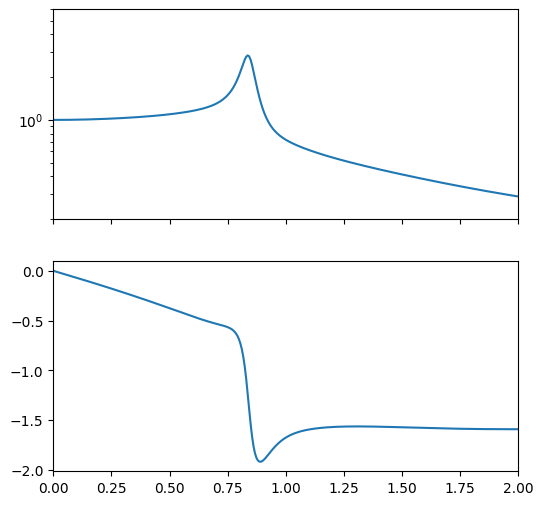

In [3]:
# Fourier transform of the step response
# Compare to transfer_function.ipynb

fs = 1 / (t[1] - t[0])

n = len(CL)
freqs = 2 * np.pi * np.fft.fftfreq(n, d=1/fs)
CL_fft = np.sqrt(1 / 2 * np.pi) * np.fft.fft(CL) / fs

CL_fft = CL_fft / CL_fft[0]

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]))
ax[0].set_ylim(0.2, 6)
ax[1].plot(freqs[:n//2], np.angle(CL_fft[:n//2]))
ax[1].set_xlim(0, 2)
plt.show()


In [4]:
flow = hgym.RotaryCylinder(
    Re=100,
    velocity_order=2,
    restart=f"{output_dir}/base.h5"
)

qB = flow.q.copy(deepcopy=True)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


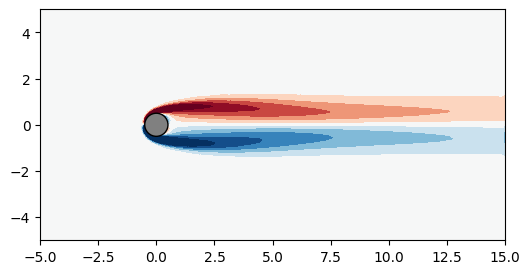

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


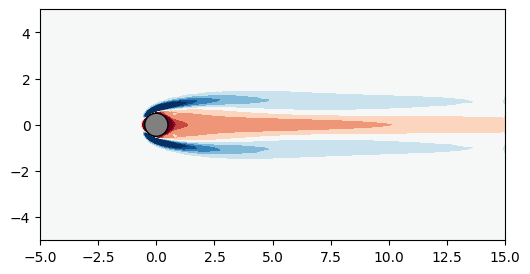

In [6]:
# 2. Derive flow field associated with actuation BC
# See Barbagallo et al. (2009) for details on the "lifting" procedure

qC = control_vec(flow)

flow.q.assign(qC)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

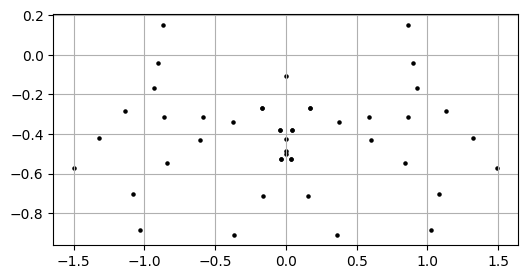

In [7]:
# 3. Global stability
# Plot eigenvalues

evals = np.load(f"{output_dir}/evals.npy")

plt.figure(figsize=(6, 3))
plt.scatter(evals.imag, evals.real, s=5, c='k')
plt.grid()
plt.show()

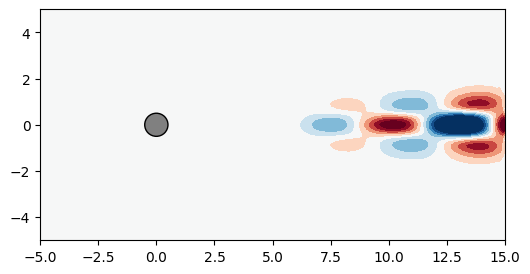

In [8]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-0.5, 0.5))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

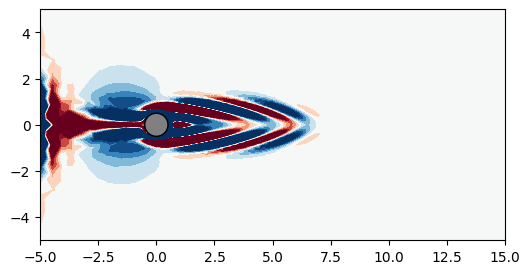

In [9]:
idx = 0
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    # mesh = chk.load_mesh("mesh")
    # q = chk.load_function(mesh, f"evec_{idx}")
    # for (u1, u2) in zip(flow.q.subfunctions, q.subfunctions):
    #     u1.project(u2)

    q = chk.load_function(flow.mesh, f"evec_{idx}")
    flow.q.assign(q)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax, clim=(-50, 50))
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

In [10]:
# Load the set of eigenvectors
r = len(evals)
tol = 1e-10
V = []
with fd.CheckpointFile(f"{output_dir}/evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        V.append(q)

W = []
with fd.CheckpointFile(f"{output_dir}/adj_evecs.h5", "r") as chk:
    for (i, w) in enumerate(evals[:r]):
        q = chk.load_function(flow.mesh, f"evec_{i}")
        W.append(q)


# Sort by real part
sort_idx = np.argsort(-evals.real)
evals = evals[sort_idx]

V = [V[i] for i in sort_idx]
W = [W[i] for i in sort_idx]

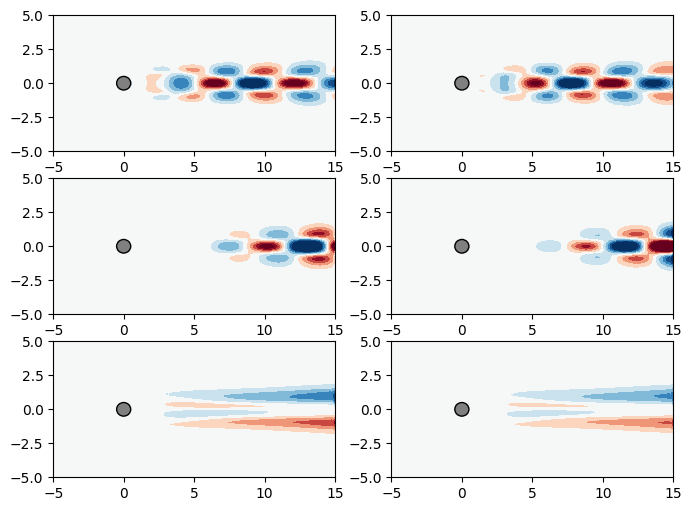

In [11]:
# Plot direct modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

clim = (-0.5, 0.5)
for i in range(0, n_plt):

    # Real part
    flow.q.assign(V[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * V[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

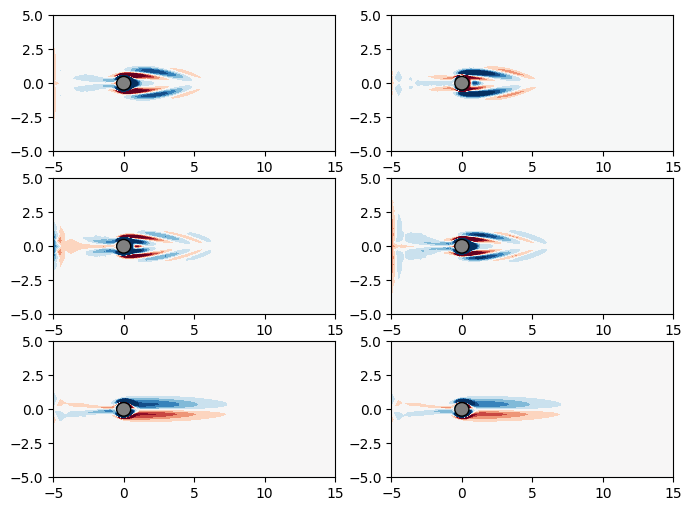

In [111]:
# Plot adjoint modes

n_plt = 3
fig, ax = plt.subplots(n_plt, 2, figsize=(8, 6))

for i in range(0, n_plt):

    alpha = flow.inner_product(W[2 * i], W[2 * i])
    clim = np.array([-1, 1]) * np.sqrt(abs(alpha))

    # Real part
    flow.q.assign(W[2 * i])
    flow.render(axes=ax[i, 0], clim=clim)
    ax[i, 0].set_xlim([-5, 15])
    ax[i, 0].set_ylim([-5, 5])
    
    # Imaginary part
    flow.q.assign(-1j * W[2 * i])
    flow.render(axes=ax[i, 1], clim=clim)
    ax[i, 1].set_xlim([-5, 15])
    ax[i, 1].set_ylim([-5, 5])

plt.show()

In [112]:
# 4. Projection onto global modes

r = 9  # Number of global modes for projection
# r = len(evals)
Ar = np.zeros((r, r), dtype=np.complex128)
Br = np.zeros((r, 1), dtype=np.complex128)
Cr = np.zeros((1, r), dtype=np.complex128)

A = flow.linearize(qB)
A.copy_output = True

def meas(q):
    flow.q.assign(q)
    CL, _CD = flow.get_observations()
    return CL

def real_part(q):
    return

for i in range(r):
    for j in range(r):
        # Ar[j, i] = flow.inner_product(A @ V[i], W[j])

        # Specifically for this projection, we know the result is diagonal
        Ar[j, i] = 0.0
        if i == j:
            if np.isclose(evals[i].imag, 0.0, atol=tol):
                Ar[j, i] = evals[i].real
            else:
                Ar[j, i] = evals[i]

    Br[i, 0] = flow.inner_product(qC, W[i])
    Cr[0, i] = meas(V[i])

# Finally the feedthrough term
Dr = meas(qC)

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


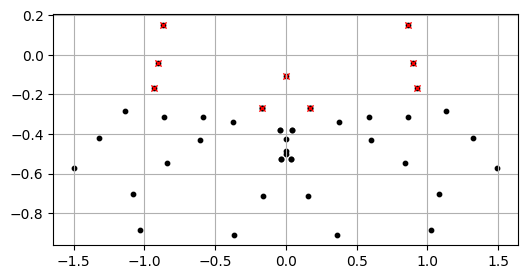

In [113]:
rom_evals = np.linalg.eigvals(Ar)
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.scatter(evals.imag, evals.real, s=10, c='k')
ax.scatter(rom_evals.imag, rom_evals.real, s=20, c='r', marker='x', linewidths=1)
ax.grid()

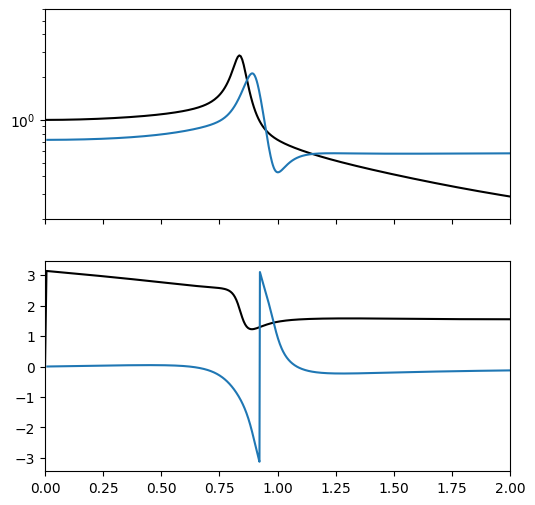

In [114]:
def H(s):
    return Cr @ np.linalg.inv(Ar - s * np.eye(r)) @ Br + Dr

omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])

fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
ax[0].semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax[0].semilogy(omega.imag, np.abs(H_omega))
ax[0].set_xlim(0, 2)
ax[0].set_ylim(0.2, 6)
ax[1].plot(freqs[:n//2], np.mod(np.angle(CL_fft[:n//2]), np.pi), 'k')
ax[1].plot(omega.imag, np.angle(H_omega))


In [115]:
# Convert the system to real form
# See: https://github.com/scipy/scipy/blob/v1.12.0/scipy/linalg/_decomp.py#L1458-L1605
from scipy import linalg

def real_form(A, B, C, D):
    w = np.diag(A)
    n = w.shape[-1]

    # get indices for each first pair of complex eigenvalues
    complex_mask = np.iscomplex(w)
    n_complex = complex_mask.sum(axis=-1)

    # find complex indices
    idx = np.nonzero(complex_mask)
    idx_stack = idx[:-1]
    idx_elem = idx[-1]

    # filter them to conjugate indices, assuming pairs are not interleaved
    j = idx_elem[0::2]
    k = idx_elem[1::2]
    stack_ind = ()
    for i in idx_stack:
        # should never happen, assuming nonzero orders by the last axis
        assert (i[0::2] == i[1::2]).all(),\
                "Conjugate pair spanned different arrays!"
        stack_ind += (i[0::2],)

    # all eigenvalues to diagonal form
    Ar = np.zeros((n, n), dtype=w.real.dtype)
    di = range(n)
    Ar[di, di] = w.real

    # complex eigenvalues to real block diagonal form
    Ar[stack_ind + (j, k)] = w[stack_ind + (j,)].imag
    Ar[stack_ind + (k, j)] = w[stack_ind + (k,)].imag

    # compute real eigenvectors associated with real block diagonal eigenvalues
    u = np.zeros((n, n), dtype=np.cdouble)
    u[di, di] = 1.0
    u[stack_ind + (j, j)] = 0.5j
    u[stack_ind + (j, k)] = 0.5
    u[stack_ind + (k, j)] = -0.5j
    u[stack_ind + (k, k)] = 0.5

    # Transform the measurement matrix
    Cr = np.real(C @ u)

    # Transform the input matrix
    Br = np.real(linalg.inv(u) @ B)

    Dr = D.real

    return Ar, Br, Cr, Dr, u


Ar_real, Br_real, Cr_real, Dr_real, T = real_form(Ar, Br, Cr, Dr)

### No control

In [17]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

tf = 100
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, constant_jacobian=True)

n_steps = int(tf // dt)
CL_nat = np.zeros(n_steps)
CD_nat = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL_nat[i], CD_nat[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_nat[i]:.4f}, CD={CD_nat[i]:.4f}")
        print(f"   u={u[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.]
t=0.01, CL=0.0096, CD=-0.0000
   u=[0.]
t=0.02, CL=0.0095, CD=-0.0000
   u=[0.]
t=0.03, CL=0.0093, CD=-0.0000
   u=[0.]
t=0.04, CL=0.0091, CD=-0.0000
   u=[0.]
t=0.05, CL=0.0089, CD=-0.0000
   u=[0.]
t=0.06, CL=0.0088, CD=-0.0000
   u=[0.]
t=0.07, CL=0.0086, CD=-0.0000
   u=[0.]
t=0.08, CL=0.0084, CD=-0.0000
   u=[0.]
t=0.09, CL=0.0082, CD=-0.0000
   u=[0.]
t=0.10, CL=0.0080, CD=-0.0000
   u=[0.]
t=0.11, CL=0.0079, CD=-0.0000
   u=[0.]
t=0.12, CL=0.0077, CD=-0.0000
   u=[0.]
t=0.13, CL=0.0075, CD=-0.0000
   u=[0.]
t=0.14, CL=0.0073, CD=-0.0000
   u=[0.]
t=0.15, CL=0.0071, CD=-0.0000
   u=[0.]
t=0.16, CL=0.0069, CD=-0.0000
   u=[0.]
t=0.17, CL=0.0067, CD=-0.0000
   u=[0.]
t=0.18, CL=0.0065, CD=-0.0000
   u=[0.]
t=0.19, CL=0.0063, CD=-0.0000
   u=[0.]
t=0.20, CL=0.0062, CD=-0.0000
   u=[0.]
t=0.21, CL=0.0060, CD=-0.0000
   u=[0.]
t=0.22, CL=0.0058, CD=-0.0000
   u=[0.]
t=0.23, CL=0.0056, CD=-0.0000
   u=[0.]
t=0.24, CL=0.0054, CD=-0.0000
   u=[0.]


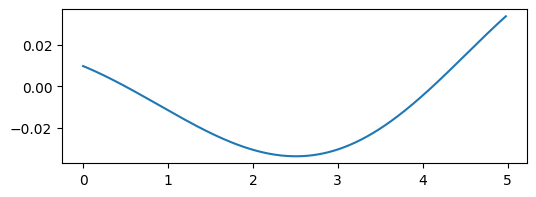

In [116]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(1, 1, figsize=(6, 2), sharex=True)
ax.plot(t, CL_nat)
plt.show()

### Controller design in the small-gain limit

See 6.2 in Barbagallo et al.

In [117]:
complex_rom = True

if complex_rom:
    A_hat, B_hat, C_hat, D_hat = Ar, Br, Cr, Dr
else:
    A_hat, B_hat, C_hat, D_hat = Ar_real, Br_real, Cr_real, Dr_real

In [136]:
ru = 2
m = 1
p = 1

Q = np.zeros((ru, ru))
R = np.eye(m)
P = linalg.solve_continuous_are(A_hat[:ru, :ru], B_hat[:ru], Q, R)

K = np.zeros_like(B_hat.T)
Ku = linalg.solve(R, B_hat[:ru].T) @ P
K[:, :ru] = Ku
Ku

# Integral control on the actuation to drive the BC value to zero
ki = 1e-1

# Q = 1e-8 * np.eye(ru)
# control.lqr(Ar[:ru, :ru], Br[:ru], Q, R)

# Kalman filter
L = np.zeros_like(C_hat.T)
Rf = np.eye(p)
Pf = linalg.solve_continuous_are(A_hat[:ru, :ru].T.conj(), C_hat[:, :ru].T.conj(), Q, Rf)
Lu = linalg.solve(Rf, C_hat[:, :ru].conj()) @ Pf
L[:ru, :] = Lu.T

In [137]:
Lu

array([[10.85026608+19.80800398j, 10.85026608-19.80800398j]])

(0.0, 2.0)

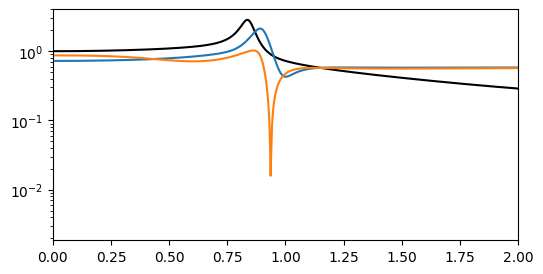

In [120]:
def H_cl(s):
    return C_hat @ np.linalg.inv((A_hat - B_hat @ K) - s * np.eye(r)) @ B_hat + D_hat

# Plot the transfer function
omega = 1j * np.linspace(0.01, 2.0, 1000)
H_omega = np.array([H(s).ravel() for s in omega])
H_cl_omega = np.array([H_cl(s).ravel() for s in omega])

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharex=True)
ax.semilogy(freqs[:n//2], np.abs(CL_fft[:n//2]), 'k')
ax.semilogy(omega.imag, np.abs(H_omega))
ax.semilogy(omega.imag, np.abs(H_cl_omega))
ax.set_xlim(0, 2)

### LQR control only

Full state measurement in the reduced basis by projecting the field at every time step. Intended for debugging only

In [24]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

c = fd.Constant(0.0)
f = c * qC.subfunctions[0].copy(deepcopy=True)

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

# solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=qC)
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, f=f)

# tf = 100
# n_steps = int(tf // dt)
CL_ctrl = np.zeros(n_steps)
CD_ctrl = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# # Integrated control signal (this is the BC value)
# c = np.zeros((n_steps, m))

rho = np.zeros(n_steps)
# rho = 0.0

flow.q.assign(solver.q)
for i in range(n_steps):
    # Project the flow field onto the reduced basis
    z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

    if i > 0:
        # Transform to the real-valued reduced state space
        x[i] = np.real(T @ z)

        # LQR control
        if complex_rom:
            u[i] = np.real(K @ z)
        else:
            u[i] = K @ x[i]

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        u[i] += 1e-1 * rho[i-1]

        c.assign(u[i])

        rho[i] = rho[i-1] - dt * u[i]

    q = solver.step()
    flow.q.assign(q)
    CL_ctrl[i], CD_ctrl[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_ctrl[i]:.4f}, CD={CD_ctrl[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=0.0
t=0.01, CL=0.0087, CD=0.0000
   u=[-0.08348229], rho=0.0008348229042186157
t=0.02, CL=0.0072, CD=0.0000
   u=[-0.08182995], rho=0.0016531223878707554
t=0.03, CL=0.0057, CD=0.0000
   u=[-0.07997622], rho=0.002452884593763159
t=0.04, CL=0.0042, CD=0.0000
   u=[-0.07805264], rho=0.0032334110428841483
t=0.05, CL=0.0028, CD=0.0000
   u=[-0.07610329], rho=0.00399444390894441
t=0.06, CL=0.0013, CD=0.0000
   u=[-0.07414301], rho=0.004735874005906559
t=0.07, CL=-0.0000, CD=0.0000
   u=[-0.07217693], rho=0.005457643306018657
t=0.08, CL=-0.0014, CD=0.0000
   u=[-0.07020691], rho=0.006159712397753057
t=0.09, CL=-0.0027, CD=0.0000
   u=[-0.06823372], rho=0.00684204962203225
t=0.10, CL=-0.0040, CD=0.0000
   u=[-0.06625778], rho=0.0075046274448618494
t=0.11, CL=-0.0052, CD=0.0000
   u=[-0.06427938], rho=0.008147421245379443
t=0.12, CL=-0.0064, CD=0.0000
   u=[-0.06229877], rho=0.00877040891000596
t=0.13, CL=-0.0076, CD=0.0000
   u=[-0.06031618], rho=0.

t=3.80, CL=0.1755, CD=0.0000
   u=[-0.07048408], rho=-0.23162344905994225
t=3.81, CL=0.1729, CD=0.0000
   u=[-0.07162506], rho=-0.23090719843915022
t=3.82, CL=0.1703, CD=0.0000
   u=[-0.07275649], rho=-0.23017963351338816
t=3.83, CL=0.1677, CD=0.0000
   u=[-0.07387826], rho=-0.22944085091651895
t=3.84, CL=0.1650, CD=0.0000
   u=[-0.07499025], rho=-0.22869094837911347
t=3.85, CL=0.1624, CD=0.0000
   u=[-0.07609237], rho=-0.22793002471506535
t=3.86, CL=0.1597, CD=0.0000
   u=[-0.07718449], rho=-0.22715817980810876
t=3.87, CL=0.1570, CD=0.0000
   u=[-0.07826652], rho=-0.22637551459824054
t=3.88, CL=0.1543, CD=0.0000
   u=[-0.07933835], rho=-0.22558213106804884
t=3.89, CL=0.1515, CD=0.0000
   u=[-0.08039988], rho=-0.22477813222894963
t=3.90, CL=0.1488, CD=0.0000
   u=[-0.08145101], rho=-0.22396362210733317
t=3.91, CL=0.1460, CD=0.0000
   u=[-0.08249164], rho=-0.22313870573062186
t=3.92, CL=0.1432, CD=0.0000
   u=[-0.08352166], rho=-0.2223034891132416
t=3.93, CL=0.1404, CD=0.0000
   u=[-0.0

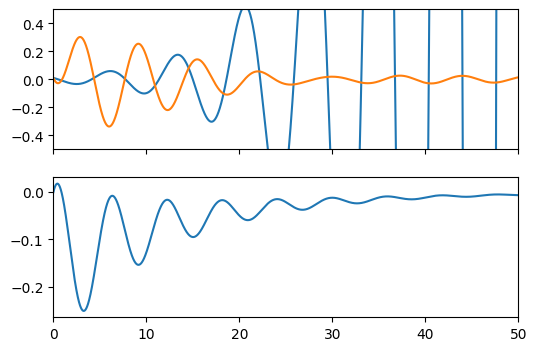

In [25]:
t = np.arange(n_steps) * dt

# y = x @ dt_sys.C.T  # Predicted CL
# print(y.shape)

fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(dt * np.arange(len(CL_nat)), CL_nat)
ax[0].plot(dt * np.arange(len(CL_ctrl)), CL_ctrl)
ax[0].set_ylim([-0.5, 0.5])
# ax[0].plot(t, y)
# ax[1].plot(t, x)
# ax[1].plot(t, u)
ax[1].plot(dt * np.arange(len(rho)), rho)
ax[1].set_xlim([0, 50])
plt.show()


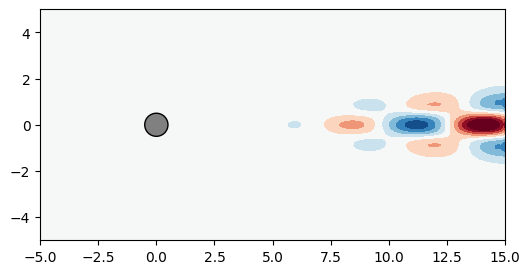

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

### Boundary condition control

In [27]:
 # The full flow field with BCs is q = qH + qC * rho, where qH is the solution
# to the homogeneous problem with forcing.  Since the controller was designed
# based on qH, this is the value we want to use for the feedback: u = K * x, with
# x = T @ z the real-valued reduced state and z = W^T @ qH = W^T @ (q - qC * rho)
# the complex-valued reduced state (in the eigenbasis).  We can pre-compute the term
# T @ (W^T @ qC) and subtract it from the full flow field projection at each step

zC = np.array([flow.inner_product(qC, W[j]) for j in range(r)])
xC = np.real(T @ zC)

# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

# Can't have a constant Jacobian here because we need to update the control,
# which changes the assembled matrix via the Dirichlet BC
solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0)

# tf = 100
# n_steps = int(tf // dt)
CL_bc = np.zeros(n_steps)
CD_bc = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r))  # Kalman filter state
u = np.zeros((n_steps, m))  # Control signal

# Integrated control signal (this is the BC value)
rho = np.zeros((n_steps, m))

flow.q.assign(solver.q)
for i in range(n_steps):

    # LQR control
    if i > 0: 
        # Project the flow field onto the reduced basis
        z = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

        # Transform to the real-valued reduced state space and offset by
        # the BC value to shift to the corresponding homogeneous solution
        x[i] = np.real(T @ z)

        # LQR control
        if complex_rom:
            u[i] = np.real(K @ (z - zC * rho[i-1]))
        else:
            u[i] = K @ (x[i] - xC * rho[i-1])

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        u[i] += 1e-1 * rho[i-1]

        # The Dirichlet boundary condition is the integrated negative control signal
        # c(t) = -drho/dt
        if i > 0:
            rho[i] = rho[i-1] - dt * u[i]

        # bc_scale = flow.advance_time(dt, c[i])[0].real
        # rho[i] = np.clip(bc_scale, -flow.MAX_CONTROL, flow.MAX_CONTROL)
        # flow.set_control(c[i])
        flow.bcu_actuation[0].set_scale(rho[i])

    q = solver.step()
    flow.q.assign(q)
    CL_bc[i], CD_bc[i] = map(np.real, flow.get_observations())

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_bc[i]:.4f}, CD={CD_bc[i]:.4f}")
        print(f"   u={u[i]}, rho={rho[i]}")

/home/firedrake/firedrake/src/pyadjoint/pyadjoint/adjfloat.py:48: ComplexWarning: Casting complex values to real discards the imaginary part
  return float.__new__(cls, *args)


t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], rho=[0.]
t=0.01, CL=0.0087, CD=0.0000
   u=[-0.08348229], rho=[0.00083482]
t=0.02, CL=0.0076, CD=0.0000
   u=[-0.0816973], rho=[0.0016518]
t=0.03, CL=0.0065, CD=0.0000
   u=[-0.07980138], rho=[0.00244981]
t=0.04, CL=0.0055, CD=0.0000
   u=[-0.07786601], rho=[0.00322847]
t=0.05, CL=0.0045, CD=-0.0000
   u=[-0.07591508], rho=[0.00398762]
t=0.06, CL=0.0035, CD=-0.0000
   u=[-0.07395671], rho=[0.00472719]
t=0.07, CL=0.0026, CD=-0.0000
   u=[-0.07199375], rho=[0.00544713]
t=0.08, CL=0.0017, CD=-0.0000
   u=[-0.07002728], rho=[0.0061474]
t=0.09, CL=0.0008, CD=-0.0000
   u=[-0.06805784], rho=[0.00682798]
t=0.10, CL=-0.0000, CD=-0.0000
   u=[-0.06608574], rho=[0.00748883]
t=0.11, CL=-0.0009, CD=-0.0000
   u=[-0.06411126], rho=[0.00812995]
t=0.12, CL=-0.0017, CD=-0.0000
   u=[-0.06213462], rho=[0.00875129]
t=0.13, CL=-0.0025, CD=-0.0000
   u=[-0.06015606], rho=[0.00935285]
t=0.14, CL=-0.0032, CD=-0.0000
   u=[-0.05817582], rho=[0.00993461]
t=0.15, CL=-0.

t=2.59, CL=0.1605, CD=0.0000
   u=[0.09508988], rho=[-0.21784592]
t=2.60, CL=0.1607, CD=0.0000
   u=[0.09389358], rho=[-0.21878486]
t=2.61, CL=0.1609, CD=0.0000
   u=[0.09268798], rho=[-0.21971174]
t=2.62, CL=0.1611, CD=0.0000
   u=[0.09147322], rho=[-0.22062647]
t=2.63, CL=0.1613, CD=0.0000
   u=[0.09024945], rho=[-0.22152896]
t=2.64, CL=0.1614, CD=0.0000
   u=[0.08901685], rho=[-0.22241913]
t=2.65, CL=0.1616, CD=0.0000
   u=[0.08777557], rho=[-0.22329689]
t=2.66, CL=0.1617, CD=0.0000
   u=[0.08652577], rho=[-0.22416214]
t=2.67, CL=0.1618, CD=0.0000
   u=[0.0852676], rho=[-0.22501482]
t=2.68, CL=0.1619, CD=0.0000
   u=[0.08400124], rho=[-0.22585483]
t=2.69, CL=0.1619, CD=0.0000
   u=[0.08272683], rho=[-0.2266821]
t=2.70, CL=0.1619, CD=0.0000
   u=[0.08144456], rho=[-0.22749655]
t=2.71, CL=0.1620, CD=0.0000
   u=[0.08015457], rho=[-0.22829809]
t=2.72, CL=0.1620, CD=0.0000
   u=[0.07885703], rho=[-0.22908666]
t=2.73, CL=0.1619, CD=0.0000
   u=[0.07755211], rho=[-0.22986218]
t=2.74, CL=0

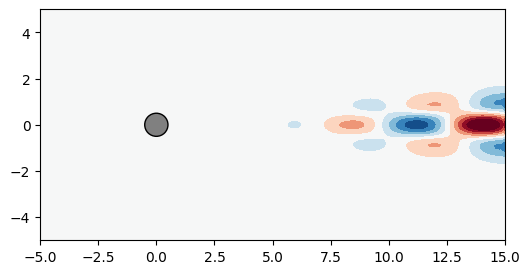

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
ax.set_xlim([-5, 15])
ax.set_ylim([-5, 5])
plt.show()

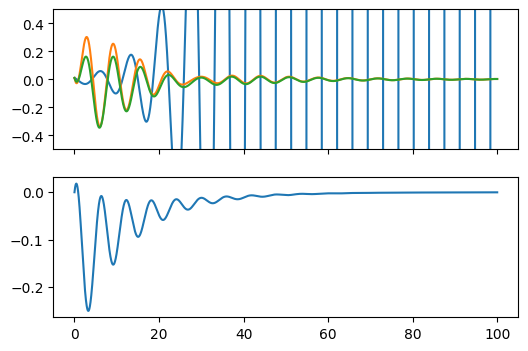

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
ax[0].plot(dt * np.arange(len(CL_nat)), CL_nat)
ax[0].plot(dt * np.arange(len(CL_ctrl)), CL_ctrl)
ax[0].plot(dt * np.arange(len(CL_bc)), CL_bc)
ax[0].set_ylim([-0.5, 0.5])

# ax[1].plot(t, CD_ctrl)
# ax[1].plot(t, CD_bc)

# ax[1].plot(dt * np.arange(len(rho)), x - xC * rho)
# ax[1].plot(dt * np.arange(len(rho)), x)
ax[1].plot(dt * np.arange(len(rho)), rho)

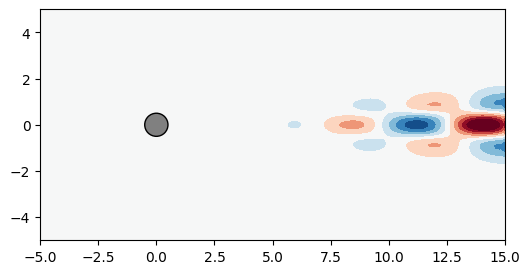

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
flow.render(axes=ax)
plt.show()

# NEXT STEPS

* Kalman filter: test estimation while keeping full-state feedback
* LQG: combine Kalman filter with LQR
* BPOD: collect snapshots from direct and adjoint simulations
* Balanced model reduction for stable subspace

# Kalman filter

Still use full-state feedback control, but test KF implementation

In [121]:
# kf_sys = control.ss(A_hat, np.hstack((B_hat, L)), C_hat, np.hstack((D_hat, [0.0])))
# np.hstack((B_hat, L)).shape

# Zero-order hold discretization
A_kf = linalg.expm(A_hat * dt)
B_kf = np.linalg.solve(A_hat, (A_kf - np.eye(r))) @ B_hat
C_kf = C_hat
D_kf = D_hat

### No control

In [162]:
# Kalman filter
L = np.zeros_like(C_hat.T)
Rf = np.eye(p)
Pf = linalg.solve_continuous_are(A_hat[:ru, :ru].T.conj(), C_hat[:, :ru].T.conj(), Q, Rf)
Lu = linalg.solve(Rf, C_hat[:, :ru].conj()) @ Pf
L[:ru, :] = Lu.T
Lu

array([[10.85026608+19.80800398j, 10.85026608-19.80800398j]])

In [163]:
# Zero-order hold on Kalman gains
Ld = np.linalg.solve(A_hat, (A_kf - np.eye(r))) @ L
Ld[:2]

array([[0.10772401+0.19869793j],
       [0.10772401-0.19869793j]])

In [191]:
# Kalman filter (discrete)

def design_dlqe(A, C):
    Q = np.zeros_like(A)
    R = np.eye(C.shape[0], dtype=C.dtype)
    P = linalg.solve_discrete_are(A.T.conj(), C.T.conj(), Q, R)
    L = linalg.solve(C @ P @ C.T.conj() + R, C @ P @ A.T.conj())
    return L.T.conj()

L = np.zeros_like(C_hat.T)
L[:ru, :] = design_dlqe(A_kf[:ru, :ru], C_kf[:, :ru])
L[:ru]

array([[0.14881802+0.21869796j],
       [0.14881802-0.21869796j]])

In [195]:
# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

tf = 20
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, constant_jacobian=True)

n_steps = int(tf // dt)
CL_nat = np.zeros(n_steps)
CD_nat = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r), dtype=A_hat.dtype)  # Reduced state
z = np.zeros((n_steps, r), dtype=A_hat.dtype)  # Kalman filter estimate
y = np.zeros((n_steps, p))  # Measurement
y_hat = np.zeros((n_steps, p))  # Kalman filter output
u = np.zeros((n_steps, m))  # Control signal

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL, CD = map(np.real, flow.get_observations())
    CL_nat[i], CD_nat[i] = CL, CD

    # Project the flow field onto the reduced basis
    x[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

    # Update the Kalman filter estimate 
    y[i] = CL
    if i > 0:
        y_hat[i] = np.real(C_kf @ (A_kf @ z[i-1] + B_kf @ u[i-1]) + D_kf * u[i-1])
        z[i] = A_kf @ z[i-1] + B_kf @ u[i-1] + L @ (y[i] - y_hat[i])

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_nat[i]:.4f}, CD={CD_nat[i]:.4f}")
        print(f"   u={u[i]}, y={y[i]}, y_hat={y_hat[i]}")

t=0.00, CL=0.0098, CD=-0.0000
   u=[0.], y=[0.00978918], y_hat=[0.]
t=0.01, CL=0.0096, CD=-0.0000
   u=[0.], y=[0.00963618], y_hat=[0.]
t=0.02, CL=0.0095, CD=-0.0000
   u=[0.], y=[0.00946944], y_hat=[5.83910763e-05]
t=0.03, CL=0.0093, CD=-0.0000
   u=[0.], y=[0.00929729], y_hat=[0.00011558]
t=0.04, CL=0.0091, CD=-0.0000
   u=[0.], y=[0.00912251], y_hat=[0.00017154]
t=0.05, CL=0.0089, CD=-0.0000
   u=[0.], y=[0.00894603], y_hat=[0.00022625]
t=0.06, CL=0.0088, CD=-0.0000
   u=[0.], y=[0.00876817], y_hat=[0.00027971]
t=0.07, CL=0.0086, CD=-0.0000
   u=[0.], y=[0.00858905], y_hat=[0.00033189]
t=0.08, CL=0.0084, CD=-0.0000
   u=[0.], y=[0.0084087], y_hat=[0.0003828]
t=0.09, CL=0.0082, CD=-0.0000
   u=[0.], y=[0.00822714], y_hat=[0.00043243]
t=0.10, CL=0.0080, CD=-0.0000
   u=[0.], y=[0.0080444], y_hat=[0.00048076]
t=0.11, CL=0.0079, CD=-0.0000
   u=[0.], y=[0.00786048], y_hat=[0.0005278]
t=0.12, CL=0.0077, CD=-0.0000
   u=[0.], y=[0.0076754], y_hat=[0.00057354]
t=0.13, CL=0.0075, CD=-0.0000

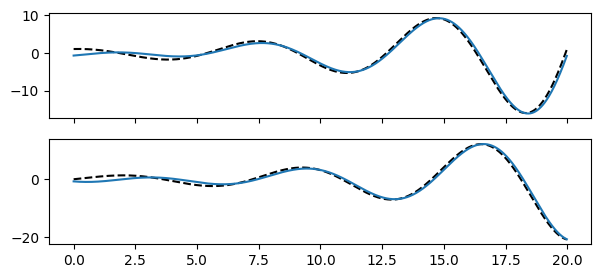

In [ ]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
z_plt = z * np.exp(1j * 5*np.pi/4)  # Phase shifted from true state
ax[0].plot(t, np.real(x[:, 0]), 'k--')
ax[0].plot(t, np.real(z_plt[:, 0]))
ax[1].plot(t, np.imag(x[:, 0]), 'k--')
ax[1].plot(t, np.imag(z_plt[:, 0]))
plt.show()

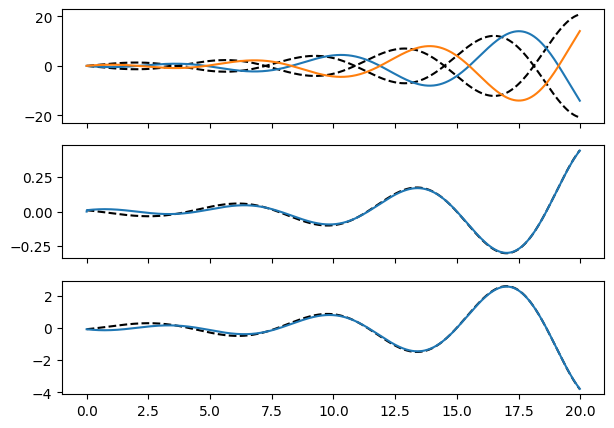

In [ ]:
t = np.arange(n_steps) * dt
fig, ax = plt.subplots(3, 1, figsize=(7, 5), sharex=True)
# ax.plot(t, CL_nat)
ax[0].plot(t, np.imag(x[:, :2]), 'k--')
ax[0].plot(t, np.imag(z[:, :2].conj()))
ax[1].plot(t, y, 'k--')
ax[1].plot(t, y_hat)
ax[2].plot(t, x @ K.T, 'k--')
ax[2].plot(t, z.conj() @ K.T)
plt.show()

# Full LQG control

In [ ]:
zC = np.array([flow.inner_product(qC, W[j]) for j in range(r)])

# Second-order BDF time-stepping
lin_flow = flow.linearize(qB)
fn_space = lin_flow.function_space
bcs = lin_flow.bcs

J = lin_flow.J

q0 = fd.project(ufl.real(V[0]), fn_space)
q0.assign(q0 / flow.inner_product(q0, q0))

tf = 20
dt = 0.01

solver = LinearBDFSolver(fn_space, J, order=2, dt=dt, bcs=bcs, q0=q0, constant_jacobian=True)

n_steps = int(tf // dt)
CL_lqg = np.zeros(n_steps)
CD_lqg = np.zeros(n_steps)

m = 1

x = np.zeros((n_steps, r), dtype=A_hat.dtype)  # Reduced state
z = np.zeros((n_steps, r), dtype=A_hat.dtype)  # Kalman filter estimate
y = np.zeros((n_steps, p))  # Measurement
y_hat = np.zeros((n_steps, p))  # Kalman filter output
u = np.zeros((n_steps, m))  # Control signal

# Integrated control signal (this is the BC value)
rho = np.zeros((n_steps, m))

flow.q.assign(solver.q)
for i in range(n_steps):
    q = solver.step()
    flow.q.assign(q)
    CL, CD = map(np.real, flow.get_observations())
    CL_nat[i], CD_nat[i] = CL, CD

    # Project the flow field onto the reduced basis
    x[i] = np.array([flow.inner_product(flow.q, W[j]) for j in range(r)])

    # Update the Kalman filter estimate 
    y[i] = CL
    if i > 0:
        y_hat[i] = np.real(C_kf @ (A_kf @ z[i-1] + B_kf @ u[i-1]) + D_kf * u[i-1])
        z[i] = A_kf @ z[i-1] + B_kf @ u[i-1] + L @ (y[i] - y_hat[i])
    
        # LQR control
        u[i] = np.real(K @ (z[i] - zC * rho[i-1]))

        # Small proportional control applied to the actuation to
        # drive the BC value to zero
        u[i] += 1e-1 * rho[i-1]

        # The Dirichlet boundary condition is the integrated negative control signal
        # c(t) = -drho/dt
        rho[i] = rho[i-1] - dt * u[i]

        # bc_scale = flow.advance_time(dt, c[i])[0].real
        # rho[i] = np.clip(bc_scale, -flow.MAX_CONTROL, flow.MAX_CONTROL)
        # flow.set_control(c[i])
        flow.bcu_actuation[0].set_scale(rho[i])

    if i % 1 == 0:
        print(f"t={i*dt:.2f}, CL={CL_nat[i]:.4f}, CD={CD_nat[i]:.4f}")
        print(f"   u={u[i]}, y={y[i]}, y_hat={y_hat[i]}")

In [33]:
flow.MAX_CONTROL

1.5707963267948966

In [34]:
# t = np.arange(n_steps) * dt

# y = x @ dt_sys.C.T  # Predicted CL
# print(y.shape)

# fig, ax = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
# ax[0].plot(t, CL)
# ax[0].plot(t, y)
# # ax[1].plot(t, u)
# plt.show()
